## Sample Analysis for Tracker Observables

Begin by importing the allmighty `numpy` and `pyplot`

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random 

from os import listdir
import re

# Weight Events

Small bit of code which weights the simulated muon neutrinos according to the expected number of events at FaserNu

In [2]:
def weight_muon_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 1000
    numSimLead = 5 * 1000
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        energy = event['primaryEnergy']
        zpos   = event['zposition']

        mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
        numExp = expTotal[mask]
        if zpos < 120: # If interacted in tungsten
            weight = tungWeight * numExp / numSimTung
        else:
            weight = leadWeight * numExp / numSimLead

        event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element

def weight_elec_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-12.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_12.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 300
    numSimLead = 5 * 300
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        energy = event['primaryEnergy']
        zpos   = event['zposition']

        mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
        numExp = expTotal[mask]
        if zpos < 120: # If interacted in tungsten
            weight = tungWeight * numExp / numSimTung
        else:
            weight = leadWeight * numExp / numSimLead

        event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element

def weight_muons(files):
    
    data = np.array([])
    
    # Load fluence files for muons and anti-muons and combine them
    expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
    expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')
    
    expEnergy = expectedData1[:,0]
    expFlu    = expectedData1[:,1] + expectedData2[:,1]
    
    # expFlu has units of GeV^-1 cm^-2 s^-1
    # Multiply by primary energy to change to cm^-2 s^-1
#     expFlu = expFlu * expEnergy
    # Above was incorrect: Multiply by bin width (~200 GeV)
    expFlu = expFlu * 200
    
    LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC
    expFlu = expFlu / LHCflu # fb (at the LHC) * cm^-2 (per unit area at FASER)
    
    A_lr = 6.5 * 35 # left/right simulation area in cm^2
    A_tb = 43  * 4 # top/bot simulation area in cm^2
    
    expTot_lr = expFlu * A_lr
    expTot_tb = expFlu * A_tb
    
    # Number simulated in each region for each input file
    simTot = countSimTotals(files)
    
    # Controls accepted range for matching primary energy - Anything below ~200 GeV should be identical
    eps  = 0.01 # Within 10 MeV
    
    for file in files:
        tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
        side = re.match(r'.*_([a-z]*)[0-9][0-9][0-9].npy', file)[1]
        if (side == 'left') or (side == 'right'):
            expTot = expTot_lr
        elif (side == 'top') or (side == 'bot'):
            expTot = expTot_tb
        
        # Add the appropriate weight to each event
        for event in tmp:
            energy = event['primaryEnergy']
            simTotCur = simTot[side][energy]
            
            # Find which energy this primary falls into
            mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
            # Number of expected muons at this energy
            numExp = expTot[mask]
            # weight = number expected / number simulated
            event['weight'] = numExp[0] / simTotCur # Weight for 1 fb^-1 run at the LHC
        
        data = np.append(data,tmp)
    
    return data

def countSimTotals(files):
    
    simTot = {}
    for side in ['left', 'right', 'top', 'bot']:
        sideDict = {}
        sideFiles = [file for file in files if re.search(f'.*{side}.*', file)]
        for file in sideFiles:
            energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
            if not(energy in sideDict.keys()):
                sideDict[energy] = 21527
            else:
                sideDict[energy] += 21527
        simTot[side] = sideDict
            
    return simTot

The following block of code runs the weighting function on the muon neutrino data and muon data in the `NumpyArrays` directory.

In [3]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muon_neutrinos',file)]
muon_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_muon_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    muon_neutrino_data = np.append(muon_neutrino_data, tmp)

CPU times: user 5.56 s, sys: 249 ms, total: 5.81 s
Wall time: 5.81 s


In [4]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'elec_neutrinos',file)]
elec_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_elec_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    elec_neutrino_data = np.append(elec_neutrino_data, tmp)

CPU times: user 2.24 s, sys: 116 ms, total: 2.36 s
Wall time: 2.36 s


In [5]:
%%time
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muons',file)]
muon_data = weight_muons(files)

CPU times: user 1min 14s, sys: 5.48 s, total: 1min 19s
Wall time: 1min 19s


In [6]:
%%time
objects = []
for event in muon_data:
    tmp = {'energy': event['primaryEnergy'],
           'weight': event['weight']}
    if not(tmp in objects):
        objects.append(tmp)  
sorted(objects, key=lambda d: d['energy']) 

CPU times: user 1.94 s, sys: 0 ns, total: 1.94 s
Wall time: 1.94 s


[{'energy': 121.119, 'weight': 8.203202304083243},
 {'energy': 121.119, 'weight': 9.43492681586925},
 {'energy': 327.154, 'weight': 2.20121887377025},
 {'energy': 327.154, 'weight': 1.9138509592604633},
 {'energy': 524.136, 'weight': 0.5345890556045896},
 {'energy': 524.136, 'weight': 0.6148584941862696},
 {'energy': 721.13, 'weight': 0.2269856999602117},
 {'energy': 721.13, 'weight': 0.19735284154782365},
 {'energy': 924.133, 'weight': 0.1740548994286245},
 {'energy': 924.133, 'weight': 0.20018953296264952},
 {'energy': 1124.14, 'weight': 0.3244466832350072},
 {'energy': 1124.14, 'weight': 0.28858347519804134},
 {'energy': 1324.14, 'weight': 0.30551045335679683},
 {'energy': 1324.14, 'weight': 0.3434772320806429},
 {'energy': 1524.14, 'weight': 0.2505861191759186},
 {'energy': 1524.14, 'weight': 0.22288720102525142},
 {'energy': 1724.13, 'weight': 0.1519167789287871},
 {'energy': 1724.13, 'weight': 0.1351244265067945},
 {'energy': 1924.14, 'weight': 0.0936700364658336},
 {'energy': 19

In [7]:
A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2

weights = {}
for obj in objects:
    energy = obj['energy']
    weight = obj['weight']
    if not(energy in weights.keys()):
        weights[energy] = weight
    else:
        if weight > weights[energy]:
            weight_lr = weight
            weight_tb = weights[energy]
        else:
            weight_lr = weights[energy]
            weight_tb = weight
        weights[energy] = (weight_lr * A_lr + weight_tb * A_tb)/(A_lr + A_tb)

### Display event

Here is some quick event display function I wrote based on Michael's code

In [8]:
def display_event(data, ievent=0):
    
    #load event
    event = data[ievent]
    if event['scintillator'][0]> 0: return 0
    if event['scintillator'][2]==0: return 0 
    
    # initialize
    multiplier=2
    matplotlib.rcParams.update({'font.size': 15*multiplier})
    matplotlib.rcParams['axes.linewidth'] = multiplier
    fig = plt.figure(figsize=(16*multiplier,7*multiplier))
    
    # Setup some nice axes 
    x0, x1 = 0.01, 0.94
    width = (x1-x0)/4
    h_tr, h_pic, h_sc = 0.55, 0.35, 0.08
    ax0 = fig.add_axes([x0          , 0.02+h_tr      , (x1-x0)   , h_pic])    
    ax1 = fig.add_axes([x0 + 0*width, 0.02           , width     , h_tr ])
    ax2 = fig.add_axes([x0 + 1*width, 0.02           , width     , h_tr ])
    ax3 = fig.add_axes([x0 + 2*width, 0.02           , width     , h_tr ])
    ax4 = fig.add_axes([x0 + 3*width, 0.02           , 1.25*width, h_tr ])
    ax5 = fig.add_axes([x0          , 0.02+h_tr+h_pic, 0.8       , 0.05  ])
    ax6 = fig.add_axes([x0+0.8      , 0.02+h_tr+h_pic, x1-x0-0.8 , 0.05  ])
    
    #plot image of detector
    image = img.imread('Fig_Layout.jpg')
    ax0.imshow(image)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.spines.clear()
    
    # Plot the tracker images
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    for ax, layer in zip([ax1,ax2,ax3,ax4],['hits1','hits2','hits3','hits4']):
        image = np.array(event[layer])
        if len(image)==0: image = np.array([[0,0,0]])
        hist = ax.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins, 
                  norm=matplotlib.colors.LogNorm(vmin=1,vmax=100),cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(hist[3], ax=ax4)
    
    # Plot scintillators
    ax5.hist2d(np.linspace(0.5,8.5,9), np.zeros(9) , weights=event['scintillator'][:-1], bins=(np.linspace(0,9,10),[-1,1]), 
                  norm=matplotlib.colors.LogNorm(vmin=0.1,vmax=1),cmap='rainbow')
    for x in np.linspace(0,8,9): 
        ax5.plot([x,x],[-1,1],lw=multiplier,c="k")
        ax5.text(x+0.06,-0.75,str(int(x+1)))
    ax5.set_xticks([])
    ax5.set_yticks([])
    
    # Plot calorimeter
    ax6.text(0.5,0.5,"E="+str(event['calorimeter'])+" GeV",ha="center", va="center")
    ax6.fill([0,1,1,0], [0,0,1,1], c="lightgreen")
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Return figure so user can manipulate or save the plots
#     plt.savefig("EventDisplays/Event_"+str(ievent)+".pdf")
#     plt.show()
    
    return 1


In [9]:
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_neutrino_data))
#     numevents+=display_event(muon_neutrino_data, ievent=ievent)

In [10]:
# # Doing the same thing for muon data
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_data))
#     numevents+=display_event(muon_data, ievent=ievent)

# Scintillators and Calorimeter Energy

In [11]:
def emptyBarPlot(bins, counts):
    bins2 = np.append(bins,bins)
    bins2[0:len(bins2):2] = bins
    bins2[1:(len(bins2)-1):2] = bins[1:]

    counts2 = np.append(counts,counts)
    counts2[0:len(counts2):2] = counts
    counts2[1:len(counts2):2] = counts
    plt.plot(bins2, counts2)

In [12]:
def countSignalEvents(data, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)],
                      minCal = 0, weighted = True):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data
               if ((event['calorimeter'] > minCal) and (event['scintillator'][entries] == signal).all())]
    
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))
    
    count = 0
    uncertainty = 0
    
    for en in primEnergies:
        weights = [event['weight'] for event in matches if event['primaryEnergy'] == en]
        for weight in set(weights):
            mask = weights == weight
            if weighted:
                count += np.sum(np.array(weights)[mask])
                uncertainty += np.sum(np.array(weights)[mask]) / np.sqrt(np.sum(mask))
            else:
                count += np.sum(mask)
                uncertainty += np.sqrt(np.sum(mask))

    return count, uncertainty

In [13]:
def binCalEnergy(data, bins = None, requirement="True", weighted = True):

    matches = [event for event in data if eval(requirement)]
    if bins is None:
        deposits = [event['calorimeter'] for event in matches]
        minDep = min(deposits) - 1
        maxDep = max(deposits) + 1
        low = np.log10(max(10**-2, minDep)) # Sets 0.01 as the smallest bin
        high = max(3, np.log10(maxDep))     # Sets 1000 as the largest bin
        bins = np.logspace(low, high, 100)
        
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))

    binned = {'bins': bins}

    for energy in primEnergies:
        subdata = [(event['calorimeter'], event['weight']) for event in matches if event['primaryEnergy'] == energy]
        cals    = [x[0] for x in subdata]
        weights = [x[1] for x in subdata]
        
        counts = np.zeros(np.size(bins))
        uncertainties = np.zeros(np.size(bins))
        for weight in set(weights):
            mask = weights == weight
            
            cal = np.array(cals)[mask]
            ids = np.searchsorted(bins,cal)
            
            count = np.zeros(np.size(bins))
            raw_count = np.zeros(np.size(bins))
            for id_ in ids:
                try:
                    raw_count[id_] += 1
                    count[id_]     += weight
                except IndexError:
                    print(wid[0])
                    print(energy)
                    break
            if weighted:
                counts += count
                mask = raw_count > 0
                uncertainties[mask] += count[mask] / np.sqrt(raw_count[mask])
            else:
                counts += raw_count
                uncertainties += np.sqrt(raw_count)
                
        binned[energy] = (counts, uncertainties)
        
    return binned

In [14]:
def plotBinnedData(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    curCounts = np.zeros(np.size(bins))
    for energy in primaryEnergies:
        counts = data[energy][0]
        curCounts += counts * scale
        
        emptyBarPlot(bins,curCounts)
        
def plotCounts(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    totalCounts = 0
    for energy in primaryEnergies:
        counts = data[energy][0] * scale
        uncertainty = data[energy][1] * scale
        totalCounts += np.sum(counts)
        
        plt.plot(bins,counts, 'ko', markersize=4)
        plt.errorbar(bins,counts, uncertainty, fmt=' ', color='b')
    return totalCounts

def plotCountsSummed(data, scale = 1, primaryEnergies = None):
    bins = data['bins']
    if primaryEnergies is None:
        primaryEnergies = [e for e in data.keys() if isinstance(e,float)]
    
    totalCounts = 0
    totalUncertainty = 0
    for energy in primaryEnergies:
        counts = data[energy][0] * scale
        uncertainty = data[energy][1] * scale
        totalCounts += counts
        totalUncertainty += uncertainty
        
    plt.plot(bins,totalCounts, 'ko', markersize=4)
    plt.errorbar(bins,totalCounts, totalUncertainty, fmt=' ', color='b')
    return np.sum(totalCounts)

CPU times: user 6.98 s, sys: 0 ns, total: 6.98 s
Wall time: 6.98 s


Text(0, 0.5, 'Muon Expected Counts for 1 fb^-1')

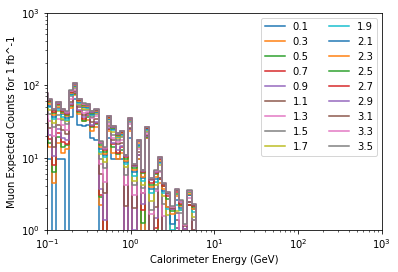

In [15]:
%%time
data1 = binSignal(muon_data)

plotBinnedData(data1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 10**3])
plt.ylim([10**0, 10**3])
energies = [e for e in data1.keys() if isinstance(e,float)]
plt.legend([str(np.round(energy,-2)/1000) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Expected Counts for 1 fb^-1');

CPU times: user 969 ms, sys: 330 µs, total: 969 ms
Wall time: 969 ms


Text(0, 0.5, 'Muon Neutrino Expected Counts for 1 fb^-1')

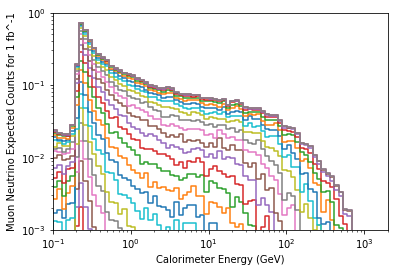

In [16]:
%%time
data2 = binSignal(muon_neutrino_data)

plotBinnedData(data2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 2*10**3])
plt.ylim([10**-3, 10**0])
energies = [e for e in data2.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Neutrino Expected Counts for 1 fb^-1');

CPU times: user 157 ms, sys: 4.3 ms, total: 161 ms
Wall time: 160 ms


Text(0, 0.5, 'Electron Neutrino Expected Counts for 1 fb^-1')

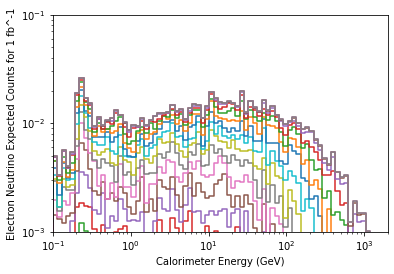

In [17]:
%%time
data3 = binSignal(elec_neutrino_data)

plotBinnedData(data3)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 2*10**3])
plt.ylim([10**-3, 10**-1])
energies = [e for e in data3.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Electron Neutrino Expected Counts for 1 fb^-1');

In [18]:
def printCounts(minCal, scale):
    
    muons = countSignalEvents(muon_data, minCal = minCal)
    muonCount = muons[0]*scale
    muonErr   = muons[1]*scale
    numus = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues   = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: \t\t\t', np.round(muonCount,2), '+/-', np.round(muonErr,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2))
    
LHCrun = 5 # in fb^-1
for minCal in [0, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts(minCal = minCal, scale = LHCrun)
    

For 5 fb^-1 and a calorimeter cut = 0 GeV: 
	Muon: 			 59750.74 +/- 2306.04 
	Muon Neutrino: 		 37.84 +/- 0.95 
	Electron Neutrino: 	 4.73 +/- 0.33
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: 			 511.79 +/- 177.95 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: 			 17.8 +/- 11.48 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22
For 5 fb^-1 and a calorimeter cut = 10 GeV: 
	Muon: 			 3.23 +/- 3.23 
	Muon Neutrino: 		 5.08 +/- 0.33 
	Electron Neutrino: 	 1.78 +/- 0.2
For 5 fb^-1 and a calorimeter cut = 15 GeV: 
	Muon: 			 1.44 +/- 1.44 
	Muon Neutrino: 		 4.07 +/- 0.29 
	Electron Neutrino: 	 1.52 +/- 0.18
For 5 fb^-1 and a calorimeter cut = 20 GeV: 
	Muon: 			 0 +/- 0 
	Muon Neutrino: 		 3.42 +/- 0.26 
	Electron Neutrino: 	 1.35 +/- 0.17
For 5 fb^-1 and a calorimeter cut = 25 GeV: 
	Muon: 			 0 +/- 0 
	Muon Neutrino: 		 2.91 +/- 0.23 
	Electron Neutrino: 	 1.2 +/- 0.15
For 5 fb^-1 and 

# Estimating rates for high energy deposits

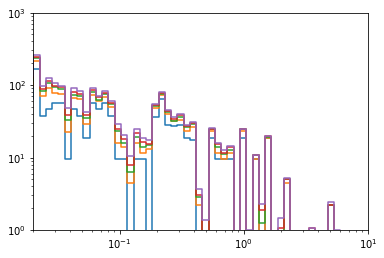

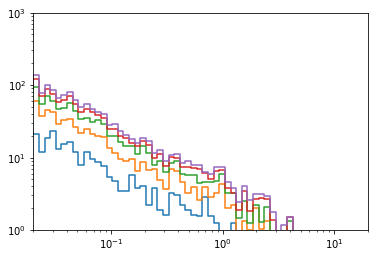

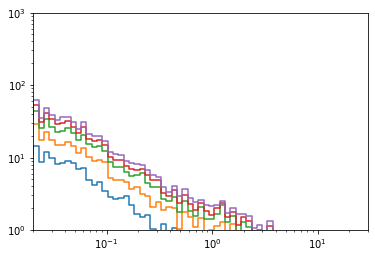

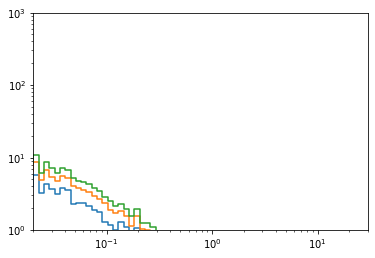

In [19]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))

mask = (primEnergies > 0) & (primEnergies < 1000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 1000) & (primEnergies < 2000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 2*10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 2000) & (primEnergies < 3000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 3*10**1])
plt.ylim([10**0, 10**3]);

plt.figure();
mask = (primEnergies > 3000)
plotBinnedData(data1, primaryEnergies = primEnergies[mask])
plt.xscale('log')
plt.yscale('log')
plt.xlim([2*10**-2, 3*10**1])
plt.ylim([10**0, 10**3]);

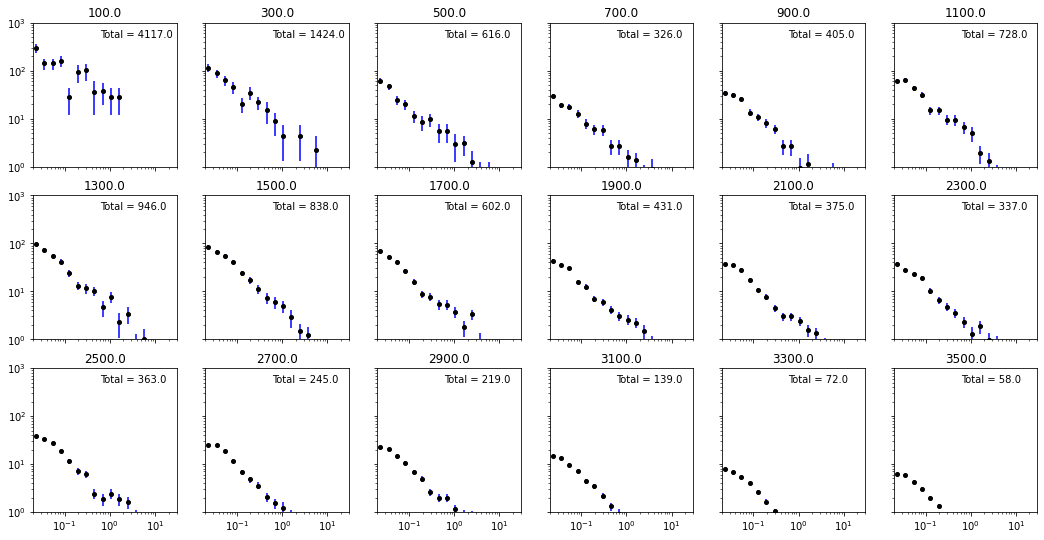

In [20]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))
data1 = binSignal(muon_data, bins=np.logspace(-2,1.5,20), weighted=True)

fig, axs = plt.subplots(3,6, sharex=True, sharey=True,  figsize=(18,9))
axs = [axs[i,j] for i in range(3) for j in range(6)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data1, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([2*10**-2, 3*10**1])
    plt.ylim([10**0, 1000]);
    plt.title(str(np.round(primEnergy,-2)))
    plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))

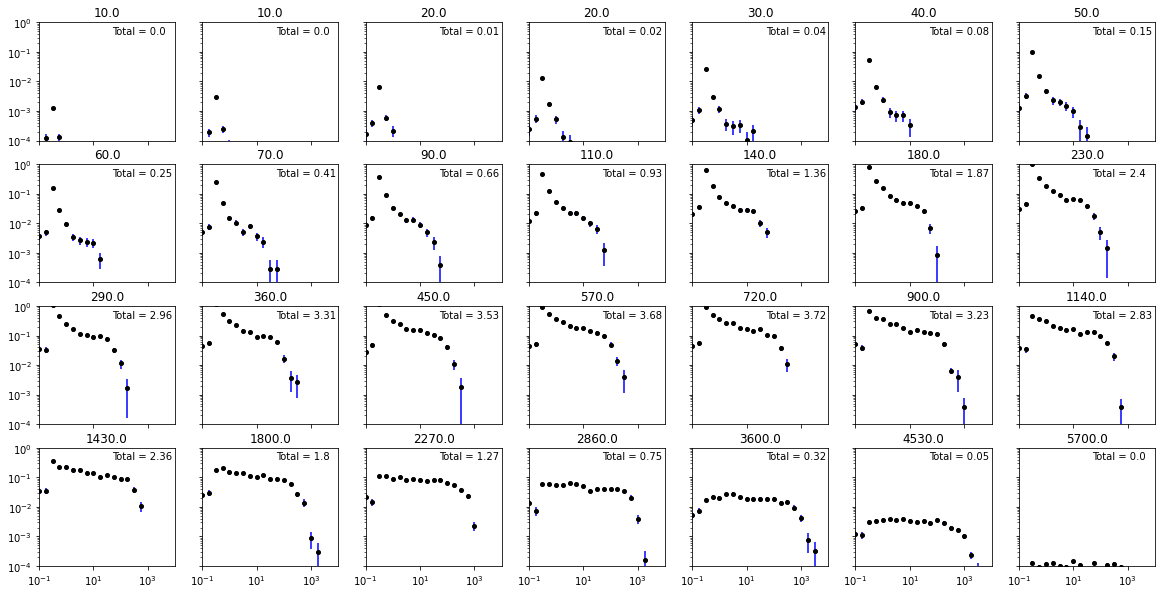

In [21]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_neutrino_data])))
data2 = binSignal(muon_neutrino_data, bins=np.logspace(-2,4,25), weighted=True)

scale = 5
fig, axs = plt.subplots(4,7, sharex=True, sharey=True, figsize=(20,10))
axs = [axs[i,j] for i in range(4) for j in range(7)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data2, primaryEnergies = [primEnergy], scale = scale)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**4])
    plt.ylim([10**-4, 10**0]);
    plt.title(str(np.round(primEnergy,-1)))
    plt.text(5*10**1, 4*10**-1,'Total = ' + str(np.round(counts,2)))

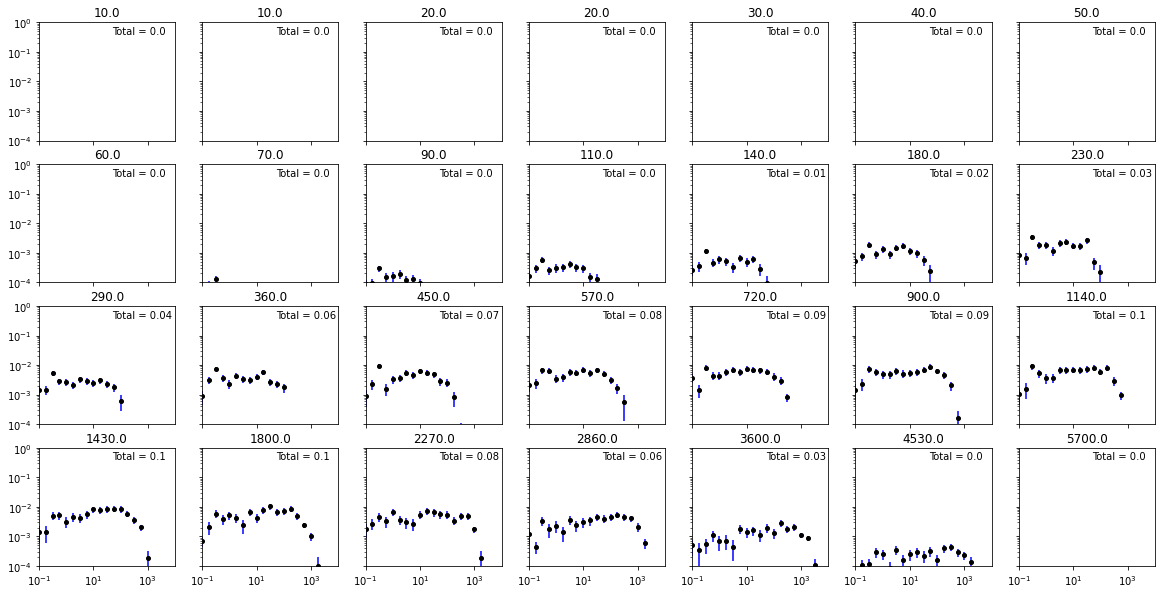

In [22]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in elec_neutrino_data])))
data3 = binSignal(elec_neutrino_data, bins=np.logspace(-2,4,25), weighted=True)

fig, axs = plt.subplots(4,7, sharex=True, sharey=True, figsize=(20,10))
axs = [axs[i,j] for i in range(4) for j in range(7)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data3, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**4])
    plt.ylim([10**-4, 10**0]);
    plt.title(str(np.round(primEnergy,-1)))
    plt.text(5*10**1, 4*10**-1,'Total = ' + str(np.round(counts,2)))

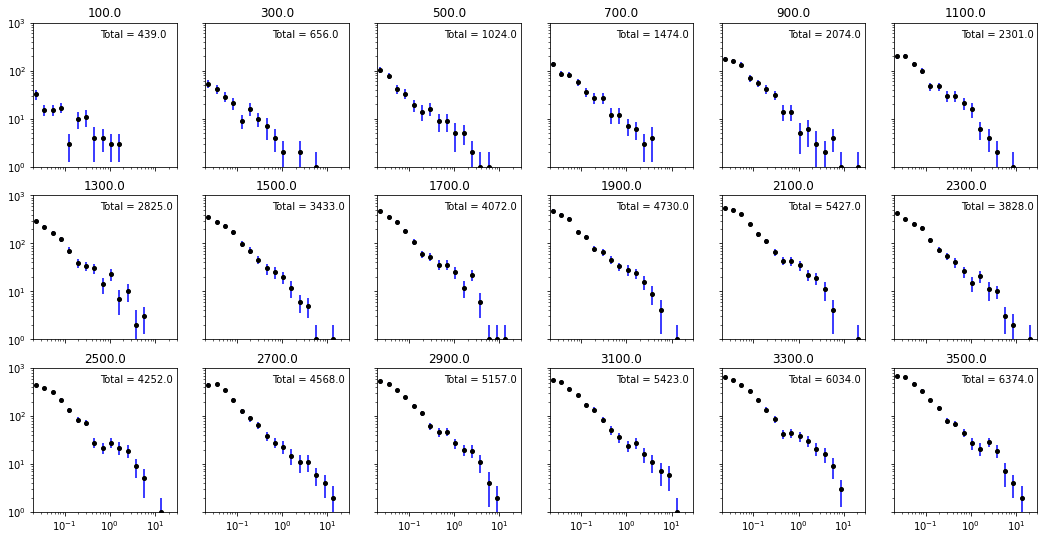

In [23]:
primEnergies = np.array(sorted(set([event['primaryEnergy'] for event in muon_data])))
data1_unweighted = binSignal(muon_data, bins=np.logspace(-2,1.5,20), weighted=False)

fig, axs = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
axs = [axs[i,j] for i in range(3) for j in range(6)]
for (primEnergy, ax) in zip(primEnergies,axs):
    plt.sca(ax)
    counts = plotCounts(data1_unweighted, primaryEnergies = [primEnergy])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([2*10**-2, 3*10**1])
    plt.ylim([10**0, 1000]);
    plt.title(str(np.round(primEnergy,-2)))
    plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))

In [24]:
from sklearn.linear_model import LinearRegression


def modelData(binData, minEnergy=0):
    bins = binData['bins']
    energyMask = bins > minEnergy
    primaryEnergies = [e for e in binData.keys() if isinstance(e,float)]

    models = {}
    x1 = np.reshape(np.log10(bins),(np.size(bins),1))[energyMask]
    x2 = np.reshape(bins,(np.size(bins),1))[energyMask]
    X = np.append(-x1,-x2,1)
    for en in primaryEnergies:
        y = binData[en][0][energyMask]
        err = binData[en][1][energyMask]
        
        # zeros are problematic in division and logs
        mask = y > 0
        err = 1/np.log(10) * err[mask]/y[mask]
        y = np.reshape(np.log10(y[mask]),(np.sum(mask),1))
        weights = 1/err

        # Fit the weighted linear model
        model = LinearRegression().fit(X[mask,:], y, weights)
        y_pred = model.predict(X[mask,:])
        
        # Compute covariance matrix
        r2 = np.dot((y-y_pred).transpose(),np.dot(np.diag(weights),(y-y_pred)))
        N, p = np.shape(X[mask,:])
        p = p + 1
        X_with_const = np.zeros((N,p))
        X_with_const[:,0] = 1
        X_with_const[:,1:] = X[mask,:]
        covMat = r2 / (N-p) * np.linalg.inv(np.dot(X_with_const.transpose(),np.dot(np.diag(weights),X_with_const)))
        
        models[en] = (model, covMat)
    
    return models

def predModel(model, covMat, energies):
        
    coefs = model.coef_
    intercept = model.intercept_

    a = coefs[0][0]
    b = coefs[0][1] * np.log(10)
    C = 10 ** intercept[0]

    scaling = np.diag([1/(np.log(10) * C), 1, 1/np.log(10)])
    covMat = np.dot(scaling, np.dot(covMat, scaling))

    y_mean = C * energies ** -a * np.exp(-b*energies)
    dydC = y_mean / C
    dyda = - np.log(energies) * y_mean
    dydb = - y_mean / energies
    dy = np.array([dydC, dyda, dydb])

    y_err = np.sqrt(np.einsum('ji,jk,ki->i', dy, covMat, dy))
    
    return y_mean, y_err

def plotModels(binData, models, weights = None):
    primaryEnergies = models.keys()
    x1 = np.linspace(-3,2,1000)
    energies = 10 ** x1

    fig, axs = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
    axs = [axs[i,j] for i in range(3) for j in range(6)]
    for (primEnergy, ax) in zip(primaryEnergies,axs):
        if weights is None:
            weight = 1
        else:
            weight = weights[primEnergy]
            
        plt.sca(ax)
        counts = plotCounts(binData, primaryEnergies = [primEnergy])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([10**-2, 10**2]);
        plt.xticks([10**-2, 10**-1, 10**0, 10**1, 10**2])
        plt.ylim([10**-1, 10**3]);
        plt.title(str(np.round(primEnergy,-2)))
        plt.text(6*10**-1, 5*10**2,'Total = ' + str(np.round(counts)))
        
        model  = models[primEnergy][0]
        covMat = models[primEnergy][1]
        
        y_mean, y_err = predModel(model, covMat, energies)
        
        plt.plot(energies, y_mean, '--r')
        plt.fill_between(energies, y_mean-y_err, y_mean+y_err, color='r', alpha=0.2)
    return fig

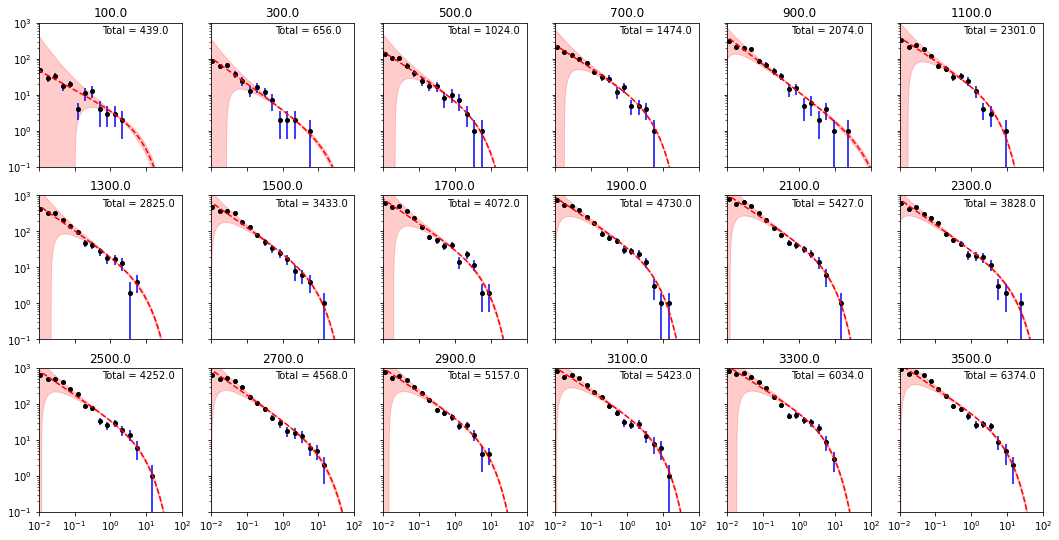

In [25]:
unweighted_muons = binSignal(muon_data, bins=np.logspace(-3,2,25), weighted=False)
unweighted_models = modelData(unweighted_muons, minEnergy=10**-2)
plotModels(unweighted_muons,unweighted_models);

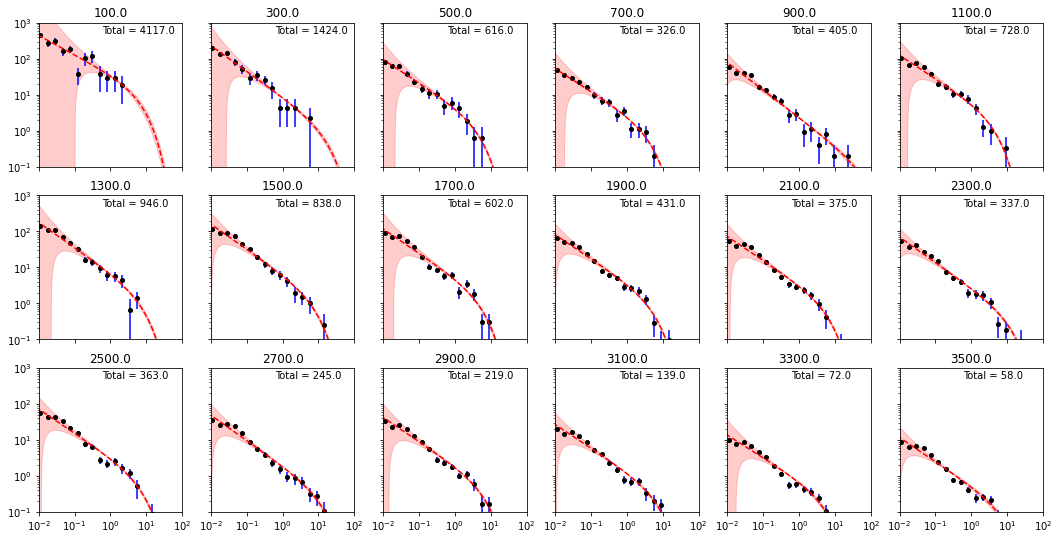

In [26]:
weighted_muons = binSignal(muon_data, bins=np.logspace(-3,2,25))
weighted_models = modelData(weighted_muons, minEnergy=10**-2)
fig = plotModels(weighted_muons, weighted_models);
fig.savefig('GeneratedPlots/background_models.pdf')

In [27]:
from scipy.integrate import quad

def integrand1(x, a, b):
    return x ** -a * np.exp(-b*x)

def integrand2(x, a, b):
    return np.log(x) * integrand1(x, a, b)

def integrateModel(models, E_min = 1):
    count = 0
    uncer = 0
    
    for (model, covMat) in models.values():
        coefs = model.coef_
        intercept = model.intercept_
        
        a = coefs[0][0]
        b = coefs[0][1] * np.log(10)
        C = 10 ** intercept[0]
        
        scaling = np.diag([1/(np.log(10) * C), 1, 1/np.log(10)])
        covMat = np.dot(scaling, np.dot(covMat, scaling))
                
        I = - C * np.diff(quad(integrand1, E_min, np.inf, args=(a,b)))
        dIda = - C * np.diff(quad(integrand2, E_min, np.inf, args=(a,b)))
        dIdb = - C * np.diff(quad(integrand1, E_min, np.inf, args=(a-1,b)))
        dIdC = I / C
        
        dI = np.array([dIdC, dIda, dIdb])
        
        cov_I2 = np.dot(dI.transpose(),np.dot(covMat,dI))[0]
        
        count += I
        uncer += np.sqrt(cov_I2)
    return count[0], uncer[0]


for E_min in [1, 5, 10, 15, 20, 25, 30]:
    print(integrateModel(weighted_models, E_min = E_min))

(267.44831286341554, 46.462731869187515)
(109.4793315851537, 36.018512851877304)
(51.15180255370374, 24.556576419867664)
(28.019744052478465, 16.36355798629295)
(17.162768690528235, 11.007780428376554)
(11.49895695962148, 7.624629785686951)
(8.281398255279312, 5.502471808240003)


In [28]:
from scipy.integrate import simpson

def integrateModel_num(models, E_min = 1, E_max = 10000, n=1000000):
    
    value = 0
    error = 0
    
    energies = np.linspace(E_min, E_max, n)
    
    for (model, covMat) in models.values():
        y_mean, y_err = predModel(model, covMat, energies)
        
        value += simpson(y_mean, energies)
        error += simpson(y_err, energies)
    return value, error

def integrateModel2_num(model, covMat, E_min = 1, E_max = 1000, n=100000):
     
    energies = np.linspace(E_min, E_max, n)
    y_mean, y_err = predSummedModel(model, covMat, energies)

    value = simpson(y_mean, energies)
    error = simpson(y_err, energies)
    return value, error

for E_min in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    print(integrateModel(weighted_models, E_min = E_min))
    print(integrateModel_num(weighted_models, E_min = E_min))

(267.44831286341554, 46.462731869187515)
(267.44831780400557, 31.27537341149957)
(109.4793315851537, 36.018512851877304)
(109.47933196529759, 21.05869295597011)
(51.15180255370374, 24.556576419867664)
(51.15180272418914, 11.571313894749037)
(28.019744052478465, 16.36355798629295)
(28.01974432374436, 6.712518569393526)
(17.162768690528235, 11.007780428376554)
(17.16276888220013, 4.176063896743269)
(11.49895695962148, 7.624629785686951)
(11.498957067494425, 2.7921406104805415)
(8.281398255279312, 5.502471808240003)
(8.281398412463115, 1.9972127494961884)
(6.31111100955514, 4.157161917135657)
(6.311111584887243, 1.5141909515446526)
(5.021134307953819, 3.2839098201285264)
(5.021134804188641, 1.2029866692139113)
(4.125733266573959, 2.697819926600531)
(4.125733581851088, 0.9906237026025053)
(3.472604857375171, 2.2885898534701874)
(3.472605066822726, 0.8378383489728428)


In [29]:
def printCounts(minCal, scale):
    
    muons_sim     = countSignalEvents(muon_data, minCal = minCal)
    muonCount_sim = muons_sim[0]*scale
    muonErr_sim   = muons_sim[1]*scale
    muons_model     = integrateModel_num(weighted_models, E_min = minCal) * scale
    muonCount_model = muons_model[0]*scale
    muonErr_model   = muons_model[1]*scale
    numus     = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues      = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: (Sim)\t\t', np.round(muonCount_sim,2), '+/-', np.round(muonErr_sim,2),
          '\n\tMuon: (Model)\t\t', np.round(muonCount_model,2), '+/-', np.round(muonErr_model,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2))
    
LHCrun = 5 # in fb^-1
for minCal in [10**-1, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts(minCal = minCal, scale = LHCrun)

For 5 fb^-1 and a calorimeter cut = 0.1 GeV: 
	Muon: (Sim)		 4758.78 +/- 663.75 
	Muon: (Model)		 2073.03 +/- 291.66 
	Muon Neutrino: 		 32.79 +/- 0.88 
	Electron Neutrino: 	 3.92 +/- 0.3
For 5 fb^-1 and a calorimeter cut = 1 GeV: 
	Muon: (Sim)		 511.79 +/- 177.95 
	Muon: (Model)		 1337.24 +/- 156.38 
	Muon Neutrino: 		 12.89 +/- 0.54 
	Electron Neutrino: 	 2.92 +/- 0.26
For 5 fb^-1 and a calorimeter cut = 5 GeV: 
	Muon: (Sim)		 17.8 +/- 11.48 
	Muon: (Model)		 547.4 +/- 105.29 
	Muon Neutrino: 		 6.97 +/- 0.39 
	Electron Neutrino: 	 2.17 +/- 0.22
For 5 fb^-1 and a calorimeter cut = 10 GeV: 
	Muon: (Sim)		 3.23 +/- 3.23 
	Muon: (Model)		 255.76 +/- 57.86 
	Muon Neutrino: 		 5.08 +/- 0.33 
	Electron Neutrino: 	 1.78 +/- 0.2
For 5 fb^-1 and a calorimeter cut = 15 GeV: 
	Muon: (Sim)		 1.44 +/- 1.44 
	Muon: (Model)		 140.1 +/- 33.56 
	Muon Neutrino: 		 4.07 +/- 0.29 
	Electron Neutrino: 	 1.52 +/- 0.18
For 5 fb^-1 and a calorimeter cut = 20 GeV: 
	Muon: (Sim)		 0 +/- 0 
	Muon: (Model)		 85

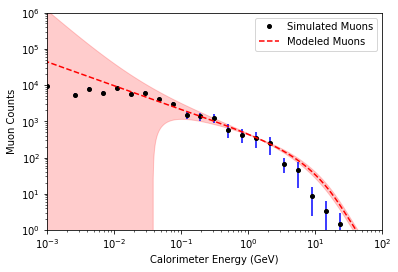

In [30]:
def plotModelsSummed(binData, models, scale = 1):
    primaryEnergies = models.keys()
    x = np.linspace(-4,3,1000)
    energies = 10 ** x
    
    fig = plt.figure()
    
    plotCountsSummed(binData, scale = scale)
    plt.xlabel('Calorimeter Energy (GeV)')
    plt.ylabel('Muon Counts')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-3, 10**2])
    plt.ylim([10**0, 10**6]);
    
    model_mean = 0
    model_err  = 0
    for (model, covMat) in models.values():
        y_mean, y_err = predModel(model, covMat, energies)
        
        model_mean += y_mean
        model_err  += y_err
    
    model_mean *= scale
    model_err *= scale
    plt.plot(energies, model_mean, '--r')
    plt.fill_between(energies, model_mean - model_err, model_mean + model_err, color='r', alpha=0.2)

    plt.legend(['Simulated Muons', 'Modeled Muons'])
    return fig

fig = plotModelsSummed(weighted_muons, weighted_models, scale = 5);
fig.savefig('GeneratedPlots/background_sim_vs_model.pdf')

In [31]:
def calcCuts(cuts, muon_data, muon_neutrino_data, elec_neutrino_data, muon_models):
    muonCount_sim = []
    muonError_sim = []
    numuCount_sim = []
    numuError_sim = []
    nueCount_sim = []
    nueError_sim = []
    muonCount_model = []
    muonError_model = []
    for cut in enCuts:
        muons_sim   = countSignalEvents(muon_data, minCal = cut)
        numus_sim   = countSignalEvents(muon_neutrino_data, minCal = cut)
        nues_sim    = countSignalEvents(elec_neutrino_data, minCal = cut)
        muons_model = integrateModel_num(muon_models, E_min = cut)
        
        muonCount_sim.append(muons_sim[0])
        muonError_sim.append(muons_sim[1])
        numuCount_sim.append(numus_sim[0])
        numuError_sim.append(numus_sim[1])
        nueCount_sim.append(nues_sim[0])
        nueError_sim.append(nues_sim[1])
        muonCount_model.append(muons_model[0])
        muonError_model.append(muons_model[1])
    return [(muonCount_sim, muonError_sim),
           (numuCount_sim, numuError_sim),
           (nueCount_sim, nueError_sim),
           (muonCount_model, muonError_model)]

enCuts = np.logspace(-1,2,30)
cuts = calcCuts(enCuts, muon_data, muon_neutrino_data, elec_neutrino_data, weighted_models)

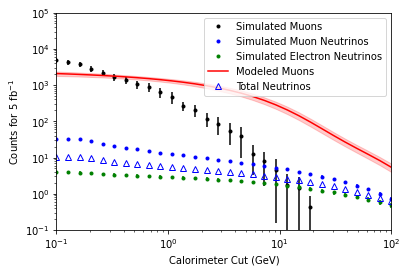

In [32]:
def plotCuts(enCuts, cuts, scale = 1):
    
    fig = plt.figure()
    for ((count, error), color) in zip(cuts,'kbgr'):
        count = np.array(count) * scale
        error = np.array(error) * scale
        if color == 'r':
            plt.plot(enCuts, count, color)
            plt.fill_between(enCuts, count-error, count+error, color=color, alpha=0.2)
        else:
            plt.plot(enCuts, count, 'o' + color, markersize=3)
            plt.errorbar(enCuts, count, error, fmt=' ', color=color)
    neutrinoCounts = np.array(cuts[1][0]) + np.array(cuts[2][0]) * scale
    neutrinoErrors = np.array(cuts[1][1]) + np.array(cuts[2][1]) * scale
    plt.plot(enCuts, neutrinoCounts, '^b', markersize=6, fillstyle='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1,10**2])
    plt.ylim([10**-1,10**5])
    plt.xlabel('Calorimeter Cut (GeV)')
    plt.ylabel('Counts for 5 fb$^{-1}$')
    plt.legend(['Simulated Muons', 'Simulated Muon Neutrinos', 'Simulated Electron Neutrinos', 'Modeled Muons', 'Total Neutrinos'])
    return fig

fig = plotCuts(enCuts, cuts, scale = 5);
fig.savefig('GeneratedPlots/expectedCounts_calorimeterCuts_2.pdf')

In [33]:
def cutData(data, calCuts):
    
    counts = []
    errors = []
    for calCut in calCuts:
        count, error = countSignalEvents(data, minCal = calCut)
        counts.append(count)
        errors.append(error)
    counts = np.array(counts)
    errors = np.array(errors)
    
    
    return {'calCuts': calCuts, 'counts': counts, 'errors': errors}

def modelSummedEvents(data):

    calCuts = data['calCuts']
    counts  = data['counts']
    errors  = data['errors']
    
    mask = counts > 0
    y = np.log(counts[mask])
    y_err = errors[mask] / y
    weights = 1 / y_err
    
    X = np.append(-np.log(calCuts[mask, np.newaxis]), -calCuts[mask, np.newaxis],1)
    
    # Fit the weighted linear model
    model = LinearRegression().fit(X, y, weights)
    y_pred = model.predict(X)
    
    # Compute covariance matrix
    r2 = np.dot((y-y_pred).transpose(),np.dot(np.diag(weights),(y-y_pred)))
    N, p = np.shape(X)
    p = p + 1
    X_with_const = np.zeros((N,p))
    X_with_const[:,0] = 1
    X_with_const[:,1:] = X
    covMat = r2 / (N-p) * np.linalg.inv(np.dot(X_with_const.transpose(),np.dot(np.diag(weights),X_with_const)))

    return model, covMat

def predSummedModel(model, covMat, x):
        
    coefs = model.coef_
    intercept = model.intercept_

    b0 = intercept
    b1 = coefs[0]
    b2 = coefs[1]

    y_mean = np.exp(b0) * x ** -b1 * np.exp(-b2*x)
    dy0 = y_mean
    dy1 = - np.log(x) * y_mean
    dy2 = - y_mean / x
    dy = np.array([dy0, dy1, dy2])
    
    y_err = np.sqrt(np.einsum('ji,jk,ki->i', dy, covMat, dy))
    
    return y_mean, y_err

def plotCutData(data, scale = 1):
    
    energies = data['calCuts']
    counts   = data['counts'] * scale
    errors   = data['errors'] * scale
    
    plt.plot(energies, counts, 'ko', markersize=3)
    plt.errorbar(energies, counts, errors, fmt=' ', color='b')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**2])
    plt.ylim([10**-1, 10**5])

def plotSummedModel(energies, model, covMat, scale = 1):
    
    y_mean, y_err = predSummedModel(model, covMat, energies)
    y_mean = y_mean * scale
    y_err  = y_err  * scale
    plt.plot(energies, y_mean, 'r--')
    y_low = y_mean - y_err
    y_high = y_mean + y_err
    plt.fill_between(energies, y_low, y_high, color='r', alpha=0.2)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1, 10**2])
    plt.ylim([10**-1, 10**5])

In [34]:
%%time
cut_muon_data = cutData(muon_data, calCuts = np.logspace(-1,2,30))

CPU times: user 13.2 s, sys: 0 ns, total: 13.2 s
Wall time: 13.2 s


In [35]:
%%time
model, covMat = modelSummedEvents(cut_muon_data)
plotCutData(cut_muon_data)
plotSummedModel(np.logspace(-1,2), model, covMat)

/usr/lib/python3/dist-packages/sklearn/linear_model/_base.py:200: RuntimeWarning: invalid value encountered in sqrt
  sample_weight = np.sqrt(sample_weight)


ValueError: array must not contain infs or NaNs

NameError: name 'model' is not defined

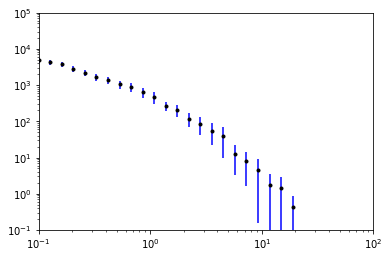

In [36]:
plotCutData(cut_muon_data, scale = 5)
plotSummedModel(np.logspace(-1,2), model, covMat, scale = 5)

In [ ]:
def printCounts2(minCal, scale):
    
    muons_sim     = countSignalEvents(muon_data, minCal = minCal)
    muonCount_sim = muons_sim[0]*scale
    muonErr_sim   = muons_sim[1]*scale
    muons_model     = predSummedModel(model, covMat, np.array([minCal]))
    muonCount_model = muons_model[0][0]*scale
    muonErr_model   = muons_model[1][0]*scale
    numus     = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues      = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    nuCount = numuCount + nueCount
    nuErr   = numuErr + nueErr
    totalCount_sim = muonCount_sim + nuCount
    totalError_sim = muonErr_sim + nuErr
    totalCount_model = muonCount_model + nuCount
    totalError_model = muonErr_model + nuErr
    portion_sim = nuCount / totalCount_sim
    portion_err_sim = (muonErr_sim) / totalCount_sim
    portion_model = nuCount / totalCount_model
    portion_err_model = (muonErr_model) / totalCount_model
    print(f'For {scale} fb^-1 and a calorimeter cut = {minCal} GeV:',
          '\n\tMuon: (Sim)\t\t', np.round(muonCount_sim,2), '+/-', np.round(muonErr_sim,2),
          '\n\tMuon: (Model)\t\t', np.round(muonCount_model,2), '+/-', np.round(muonErr_model,2),
          '\n\tMuon Neutrino: \t\t', np.round(numuCount,2), '+/-', np.round(numuErr,2),
          '\n\tElectron Neutrino: \t', np.round(nueCount,2), '+/-', np.round(nueErr,2),
          '\n\tExpected Events (Sim):\t\t', np.round(totalCount_sim,2), '+/-', np.round(totalError_sim,2),
          '\n\tPortion of Events (Sim):\t', np.round(portion_sim,2), '+/-', np.round(portion_err_sim,2),
          '\n\tExpected Events (Model):\t', np.round(totalCount_model,2), '+/-', np.round(totalError_model,2),
          '\n\tPortion of Events (Model):\t', np.round(portion_model,2), '+/-', np.round(portion_err_model,2))
    
LHCrun = 5 # in fb^-1
for minCal in [10**-1, 1, 5, 10, 15, 20, 25, 30, 35]:
    printCounts2(minCal = minCal, scale = LHCrun)

In [ ]:
from scipy import special

def binomial(p, N, n = 0):
#     if N == 0:
#         return 0
    if n > N:
        return 0
    if n == 0:
        return (1-p)**N

    return np.sum( [special.gamma(N + 1) / (special.gamma(k + 1) * special.gamma(N-k + 1))
                        * p ** k * (1-p) ** (N-k) for k in range(n+1)] )

def binomialProbUncertainty(p, N, n, s_p, s_N):
#     if N == 0:
#         return 0
    if n > N:
        return 0
    
    P = binomial(p, N, n)
    dPdp = np.sum( [P*(k / p  + N / (1-p)) * P for k in range(n+1)] )
    dPdN = np.sum( [P * (special.polygamma(0, N + 1 ) - special.polygamma(0, N - k + 1)
                  + np.log(1-p)) for k in range(n+1)] )
    
    return np.sqrt( (s_p * dPdp)**2 + (s_N * dPdN)**2 )

def poisson(N, k):
    return (N ** k) * np.exp(-N) / np.math.factorial(k)

def nullProb(minCal, scale, n = 0):
    muons     = predSummedModel(model, covMat, np.array([minCal]))
    N_mu      = muons[0][0]*scale
    s_mu      = muons[1][0]*scale
    numus     = countSignalEvents(muon_neutrino_data, minCal = minCal)
    numuCount = numus[0]*scale
    numuErr   = numus[1]*scale
    nues      = countSignalEvents(elec_neutrino_data, minCal = minCal)*scale
    nueCount  = nues[0]*scale
    nueErr    = nues[1]*scale
    N_nu      = numuCount + nueCount
    s_nu      = numuErr + nueErr
    N_tot     = N_nu + N_mu
    s_N       = s_mu + s_nu
    p = N_nu / (N_nu + N_mu)
#     s_p = np.sqrt((s_nu * N_mu)**2 + (s_mu * N_nu)**2) / (N_nu + N_mu)**2

    # Probability of Null Hypothesis (All events are muons)
    #  Poisson(N_tot, k) = probability to have k events
    #  Binomial(p, k) = probability for all k events to be muons
    #  Sum on k -> probability that no occurances have muons
    Ps = [ poisson(N_tot, k) * binomial(p, k)
                     for k in range(400) ]
    P = np.sum(Ps)
    # Uncertainty in the probability
#     s_N = 0
#     s_P = binomialProbUncertainty(p, N_tot, n, s_p, s_N)
    
    return P

for minCal in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    P = nullProb(minCal = minCal, scale = 1)

    print(minCal, ':', P)

In [ ]:
def plotSignificance(cutEnergies = np.linspace(10,100)):
    probs = np.array([nullProb(minCal = energy, scale = 5)
             for energy in cutEnergies])
    plt.plot(cutEnergies, probs)
    plt.yscale('log')

plotSignificance()

In [39]:
def calcCuts2(cuts, muon_data, muon_neutrino_data, elec_neutrino_data):
    
    data = {'cuts': cuts,
            'muon_sim'      : {},
            'muon_neutrino' : {},
            'elec_neutrino' : {}}
    for cut in cuts:
        data['muon_sim'][cut]      = countSignalEvents(muon_data, minCal = cut)
        data['muon_neutrino'][cut] = countSignalEvents(muon_neutrino_data, minCal = cut)
        data['elec_neutrino'][cut] = countSignalEvents(elec_neutrino_data, minCal = cut)
    for particle in ['muon_sim', 'muon_neutrino', 'elec_neutrino']:
        counts = np.array([count for (count, error) in data[particle].values()])
        errors = np.array([error for (count, error) in data[particle].values()])
        data[particle]['counts'] = counts
        data[particle]['errors'] = errors

    return data

enCuts = np.logspace(-1,2,30)
cuts = calcCuts2(enCuts, muon_data, muon_neutrino_data, elec_neutrino_data)

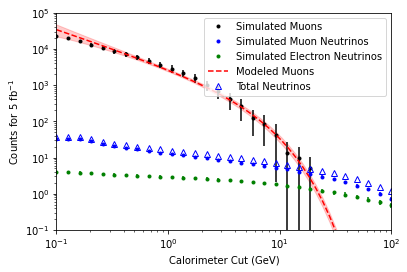

In [40]:
def plotCuts2(data, model, covMat, scale = 1):
    
    energies = data['cuts']
    
    fig = plt.figure()
    for (particle, color) in [('muon_sim', 'k'),
                              ('muon_neutrino', 'b'),
                              ('elec_neutrino', 'g')]:
        
        counts = data[particle]['counts'] * scale
        errors = data[particle]['errors'] * scale
        plt.plot(energies, counts, 'o' + color, markersize=3)
        plt.errorbar(energies, counts, errors, fmt=' ', color=color)
    plotSummedModel(np.logspace(-1,2), model, covMat, scale = scale)
    neutrinoCounts = (data['muon_neutrino']['counts'] + data['elec_neutrino']['counts']) * scale
    neutrinoErrors = (data['muon_neutrino']['errors'] + data['elec_neutrino']['errors']) * scale
    plt.plot(enCuts, neutrinoCounts, '^b', markersize=6, fillstyle='none')
#     plt.errorbar(enCuts, neutrinoCounts, neutrinoErrors, fmt=' ', color='b')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([10**-1,10**2])
    plt.ylim([10**-1,10**5])
    plt.xlabel('Calorimeter Cut (GeV)')
    plt.ylabel('Counts for 5 fb$^{-1}$')
    plt.legend(['Simulated Muons', 'Simulated Muon Neutrinos', 'Simulated Electron Neutrinos', 'Modeled Muons', 'Total Neutrinos'])
    return fig

fig = plotCuts2(cuts, model, covMat, scale = 5);
fig.savefig('GeneratedPlots/expectedCounts_calorimeterCuts.pdf')

# Attempt to Use Cluster Learning Algorithm to Classify Primary Particles

Begin by organizing the data

# TODO:
Turn tracker data into macro-observables (numhits, centrality, etc.)

In [72]:
def calcObservables(hits):
    if np.size(hits) == 0:
            return {'numHits'  : 0,
                    'meanDist' : 0,
                    'minDist'  : 0,
                    'maxDist'  : 0,
                    'medDist'  : 0,
                    'meanX'    : 0,
                    'meanY'    : 0,
                    'meanDiff' : 0,
                    'minDiff'  : 0,
                    'maxDiff'  : 0      
                    }

    xs = []
    ys = []
    numHits = 0
    for hit in hits:
        for n in range(int(hit[2])):
            xs.append(hit[0]-0.5)
            ys.append(hit[1]-0.5)
            numHits += 1
    dists = [np.sqrt(x**2 + y**2) for (x,y) in zip(xs,ys)]

    meanDist = np.mean(dists)
    minDist  = np.min(dists)
    maxDist  = np.max(dists)
    medDist  = np.median(dists)

    meanX = np.mean(xs)
    meanY = np.mean(ys)
    meanVecDist = np.sqrt(meanX**2 + meanY**2)
    diffs = np.sqrt((np.array(xs) - meanX)**2 + (np.array(ys) - meanY)**2)
    meanDiff = np.mean(diffs)
    minDiff  = np.min(diffs)
    maxDiff  = np.max(diffs)
    
    return {'numHits'  : numHits,
            'meanDist' : meanDist,
            'minDist'  : minDist,
            'maxDist'  : maxDist,
            'medDist'  : medDist,
            'meanX'    : meanX,
            'meanY'    : meanY,
            'meanDiff' : meanDiff,
            'minDiff'  : minDiff,
            'maxDiff'  : maxDiff      
            }

def eventToObservables(event, particle):
    
    newEvent = {'particle': particle, 'calorimeter': event['calorimeter']}
    for num in ['1','2','3','4']:
        observables = calcObservables(event['hits' + num])
        for (key, value) in observables.items():
            newEvent[key + num] = value
    return newEvent

Curate training data set and testing data sets

Curious if the model trained on lower energy deposits can correctly identify the high energy deposits

In [49]:
%%time
# Need this scintillator pattern to avoid cosmics and remove the first pair of scintillators
signal  = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
entries = np.array([n for n in range(10)])

muon_matches = [event for event in muon_data if (event['scintillator'][entries] == signal).all()]
numu_matches = [event for event in muon_neutrino_data if (event['scintillator'][entries] == signal).all()]
nue_matches = [event for event in elec_neutrino_data if (event['scintillator'][entries] == signal).all()]

muon_low_energies  = [event for event in muon_matches if (event['calorimeter'] <= 1)]
muon_high_energies = [event for event in muon_matches if (event['calorimeter'] > 1)]

CPU times: user 6.88 s, sys: 3.94 ms, total: 6.88 s
Wall time: 6.88 s


In [73]:
%%time
import pandas as pd

df_full = pd.DataFrame([eventToObservables(event,'muon') for event in muon_matches])
df_full = df_full.append([eventToObservables(event,'muon_neutrino') for event in numu_matches])
df_full = df_full.append([eventToObservables(event,'electron_neutrino') for event in nue_matches])

CPU times: user 49.6 s, sys: 200 ms, total: 49.8 s
Wall time: 49.8 s


In [74]:
%%time
df = pd.DataFrame([eventToObservables(event,'muon') for event in muon_low_energies])
df = df.append([eventToObservables(event,'muon_neutrino') for event in numu_matches])
df = df.append([eventToObservables(event,'electron_neutrino') for event in nue_matches])

CPU times: user 49.6 s, sys: 196 ms, total: 49.8 s
Wall time: 49.8 s


In [84]:
%%time

df_high = pd.DataFrame([eventToObservables(event,'muon') for event in
                        [event for event in muon_matches if (event['calorimeter'] > 1)]])
df_high = df_high.append([eventToObservables(event,'muon_neutrino') for event in
                        [event for event in numu_matches if (event['calorimeter'] > 1)]])
df_high = df_high.append([eventToObservables(event,'electron_neutrino') for event in
                        [event for event in nue_matches if (event['calorimeter'] > 1)]])

CPU times: user 24.7 s, sys: 31.9 ms, total: 24.7 s
Wall time: 24.7 s


In [75]:
y_train = df_full.iloc[:,0]
X_train = df_full.iloc[:,1:]

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=101)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=101)

In [77]:
df_test = pd.DataFrame([eventToObservables(event,'muon') for event in muon_high_energies])
y_test = df_test.iloc[:,0]
X_test = df_test.iloc[:,1:]

In [78]:
y_pred      = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)

In [79]:
prob = np.sum(y_pred_prob,0) / len(y_pred)

In [80]:
print(np.sum(y_pred == y_test) / len(y_pred))
print(len(y_test))

0.9337837837837838
740


In [119]:
y_train_pred      = knn.predict(X_train)
y_train_pred_prob = knn.predict_proba(X_train)

In [120]:
print(np.sum(y_train_pred == y_train) / len(y_train_pred))

0.43527924251785227


In [121]:
y_train_neutrinos = y_train.copy()
y_train_neutrinos.iloc[np.array(y_train == 'muon_neutrino')] = 'neutrino'
y_train_neutrinos.iloc[np.array(y_train == 'electron_neutrino')] = 'neutrino'

y_train_pred_neutrinos = y_train_pred.copy()
y_train_pred_neutrinos[np.array(y_train_pred == 'muon_neutrino')] = 'neutrino'
y_train_pred_neutrinos[np.array(y_train_pred == 'electron_neutrino')] = 'neutrino'

print(np.sum(y_train_neutrinos == y_train_pred_neutrinos) / len(y_train_neutrinos))

0.9294745614161123


In [122]:
y_high = df_high.iloc[:,0]
X_high = df_high.iloc[:,1:]

y_high_pred = knn.predict(X_high)

In [123]:
print(np.sum(y_high == y_high_pred) / len(y_high))

0.023957285996602296


In [124]:
y_high_neutrinos = y_high.copy()
y_high_neutrinos.iloc[np.array(y_high == 'muon_neutrino')] = 'neutrino'
y_high_neutrinos.iloc[np.array(y_high == 'electron_neutrino')] = 'neutrino'

y_high_pred_neutrinos = y_high_pred.copy()
y_high_pred_neutrinos[np.array(y_high_pred == 'muon_neutrino')] = 'neutrino'
y_high_pred_neutrinos[np.array(y_high_pred == 'electron_neutrino')] = 'neutrino'

print(np.sum(y_high_neutrinos == y_high_pred_neutrinos) / len(y_high_neutrinos))

0.9802031688797975


In [125]:
df_high

,particle,calorimeter,numHits1,meanDist1,minDist1,maxDist1,medDist1,meanX1,meanY1,meanDiff1,...,numHits4,meanDist4,minDist4,maxDist4,medDist4,meanX4,meanY4,meanDiff4,minDiff4,maxDiff4
0,muon,3.235,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,409,10.747280,0.707107,16.324828,11.597414,-0.133252,-7.150367,7.469084,0.506703,20.991325
1,muon,1.567,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,9.300538,9.300538,9.300538,9.300538,7.500000,-5.500000,0.000000,0.000000,0.000000
2,muon,2.699,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3,5.236180,2.549510,8.631338,4.527693,-2.833333,2.833333,4.012939,2.867442,5.821416
3,muon,1.532,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,200,10.644158,3.535534,16.985288,11.067972,2.735000,5.720000,8.185850,0.321908,19.530326
4,muon,8.532,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,104,11.003057,1.581139,16.985288,11.335784,-6.576923,-5.865385,6.620316,0.639260,18.767428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,neutrino,48.804,445,3.571003,0.707107,14.916434,2.915476,-2.113483,-1.122472,2.732416,...,11,8.039974,1.581139,15.116216,8.276473,-2.500000,-2.045455,7.655174,0.545455,13.246861
5680,neutrino,25.297,262,10.118511,2.121320,15.116216,10.124228,3.835878,-9.179389,1.936074,...,44,10.819582,0.707107,16.263456,11.810936,2.909091,-4.909091,8.684097,0.718699,15.491000
5681,neutrino,2.063,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2,9.392370,8.860023,9.924717,9.392370,-4.500000,-8.000000,2.061553,2.061553,2.061553
5682,neutrino,3.098,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6,8.251230,1.581139,13.285330,8.911863,-2.000000,0.500000,8.169956,3.201562,11.236103
